# Value based computations


In [1]:
#| default_exp explore

In [2]:
#| export
import numpy as np
from graphviz import Digraph
import math
import random

In [3]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [4]:
#| export 
class Value:
    
    def __init__(self, data: float, _prev:set=(), _op: str='', label='') -> None:
        self.data = data
        self._prev = _prev
        self._backward = lambda: None
        self._op = _op
        self.label = label
        self.grad: float = 0.
        
    def __repr__(self) -> str:
        return f"Value({self.data = }, {self.grad=}, {self.label = })"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else (Value(other))
        out = Value(self.data + other.data, _prev=(self,other),_op='+')
        
        def _backward():
            # we do += to manage the case where we add with itself and it overrides the gradient. So we always add grad. 
            self.grad += 1. * out.grad
            other.grad += 1. * out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self *-1
    
    def __sub__(self, other):
        return self + (-other)
        
    def __rsub__(self, other):
        return self.__sub__(other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else (Value(other))
        out =  Value(self.data * other.data, _prev=(self,other),_op='*')
    
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad            
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * (other**-1)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Other should be either int or float"
        out = Value(self.data**other, _prev=(self,), _op='**')
        
        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
            
        out._backward = _backward
        
        return out
        
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), _prev=(self,), _op='exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
        
        
    
    def tanh(self):
        x = self.data
        n = (1-math.exp(-2*x))/(1+math.exp(-2*x))
        out = Value(n, _prev=(self,), _op='tanh')
        
        def _backward():
            self.grad += (1-n**2) * out.grad
        
        out._backward = _backward
        
        return out
    
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(node: Value):
            if node not in visited:
                visited.add(node)
                for prev in node._prev:
                    build_topo(prev)
                topo.append(node)

        build_topo(self) 
        topo  
        self.grad = 1.
        for node in reversed(topo):
            node._backward()

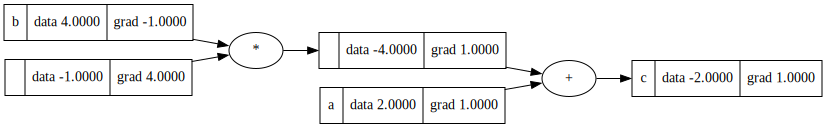

In [5]:
a = Value(2., label='a')
b = Value(4., label='b')
#a+1
#a*2
2*a
#1*a
#1+a
#a.exp()
#a/b
c=a-b; c.label='c'

c.backward()
draw_dot(c)

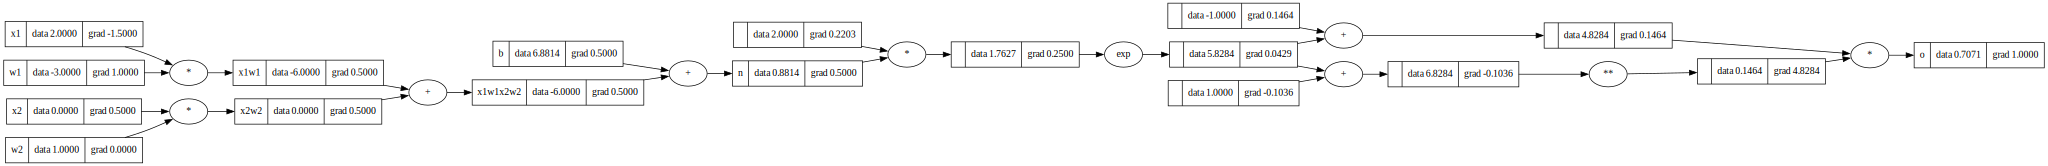

In [6]:
x1 = Value(2., label='x1')
x2 = Value(0., label='x2')

w1 = Value(-3., label='w1')
w2 = Value(1, label='w2')

x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
b = Value(6.8813735870195432, label='b')
x1w1x2w2= x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2+b; n.label='n'
e = (2*n).exp()
o = (e-1)/(e+1)
#o = n.tanh()
o.label = 'o'


#o.grad = 1.
#o._backward()
#n._backward()
#x1w1x2w2._backward()
#x1w1._backward()
##b._backward()
#x2w2._backward()
#x2._backward()
o.backward()
draw_dot(o)


In [43]:
class Module:
    def parameters(self):
        return []

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.
            


In [44]:
class Neuron(Module):
    
    def __init__(self, nin:int, activation='tanh') -> None:
        self.w = [Value(random.uniform(-1,1))for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        self.activation = activation
        
    
    def __call__(self, x):
        out = sum([wi*xi for wi,xi in zip(self.w, x)], self.b)
        if self.activation=='tanh':
            out = out.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
        
    
x =[2., 3., -1.]
n = Neuron(3)
n(x)
n.parameters()

[Value(self.data = -0.9971059929281072, self.grad=0.0, self.label = ''),
 Value(self.data = -0.8807780117302193, self.grad=0.0, self.label = ''),
 Value(self.data = -0.6076828569665591, self.grad=0.0, self.label = ''),
 Value(self.data = 0.8000979300550568, self.grad=0.0, self.label = '')]

In [45]:
class Layer(Module):
    
    def __init__(self, nin, nout) -> None:
        self.neurons = [Neuron(nin)for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    
l = Layer(3,4)
l(x)
l.parameters()

[Value(self.data = -0.5972102608880838, self.grad=0.0, self.label = ''),
 Value(self.data = 0.3187799512837819, self.grad=0.0, self.label = ''),
 Value(self.data = -0.8474778376863856, self.grad=0.0, self.label = ''),
 Value(self.data = -0.8549645427343755, self.grad=0.0, self.label = ''),
 Value(self.data = 0.525780051404636, self.grad=0.0, self.label = ''),
 Value(self.data = -0.22244196961165574, self.grad=0.0, self.label = ''),
 Value(self.data = -0.67973925887466, self.grad=0.0, self.label = ''),
 Value(self.data = 0.45641825802869085, self.grad=0.0, self.label = ''),
 Value(self.data = 0.2769150110951577, self.grad=0.0, self.label = ''),
 Value(self.data = -0.9100032163060143, self.grad=0.0, self.label = ''),
 Value(self.data = -0.7530323611752454, self.grad=0.0, self.label = ''),
 Value(self.data = 0.009843705566381145, self.grad=0.0, self.label = ''),
 Value(self.data = -0.20882932342342642, self.grad=0.0, self.label = ''),
 Value(self.data = -0.9284434175189096, self.grad=0.0,

In [46]:
class MLP(Module):
    
    def __init__(self, nin, nouts) -> None:
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) 
                       for i 
                       in range(len(nouts))]
        
        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x
    
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]
        


In [47]:
m = MLP(3,[4,4,1])
out = m(x)


In [48]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets



In [49]:
lr = 0.05
for k in range(50):
    # forward pass
    ypred =[m(x) for x in xs]
    loss = sum([(ygt-yout)**2 for ygt, yout in zip(ys, ypred)])
    print(k, loss.data)   
    
    # backward pass
    # zero out grads because during backward we do a += so we accumulate past gradients. We must flush gradient to 0.
    m.zero_grad()
    loss.backward()
    
    # parameter update
    for p in m.parameters():
        p.data += -lr*p.grad
     

0 6.0071727951711615
1 3.6927839312291315
2 2.796605711831348
3 2.0812543882040364
4 1.5274268852574922
5 1.0993345559462764
6 0.7998791393344546
7 0.6010410835580166
8 0.46866647419190116
9 0.37791888144132574
10 0.31333707329699767
11 0.2657253908095853
12 0.22952421829462288
13 0.20126092280138647
14 0.17869220954746792
15 0.16032111257215065
16 0.14511850751164349
17 0.1323577293114824
18 0.12151331294205148
19 0.11219715101063912
20 0.10411712983545093
21 0.0970496511637027
22 0.09082095761324757
23 0.0852941755290128
24 0.08036015373761313
25 0.075930873957772
26 0.07193463606699722
27 0.06831248932562246
28 0.06501555205790052
29 0.06200297406127481
30 0.059240370204669046
31 0.05669860373682848
32 0.054352832124021824
33 0.05218175207178924
34 0.050166997170451526
35 0.0482926535712603
36 0.04654486773145462
37 0.04491152655971817
38 0.04338199492885009
39 0.041946898969408994
40 0.040597946144477884
41 0.03932777506290232
42 0.038129829481339174
43 0.03699825209297394
44 0.035

In [50]:
ypred

[Value(self.data = 0.9233161011088319, self.grad=-0.15336779778233622, self.label = ''),
 Value(self.data = -0.8908098079990777, self.grad=0.21838038400184456, self.label = ''),
 Value(self.data = -0.9374605101075525, self.grad=0.12507897978489502, self.label = ''),
 Value(self.data = 0.9018757122788744, self.grad=-0.19624857544225116, self.label = '')]

# Should we do the demo.ipynb of micrograd with a more complex example ???

In [ ]:
draw_dot(loss)